In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

import jax
from jax import jit
from jax.lib import xla_bridge
print(f"Jax is using: {xla_bridge.get_backend().platform}")

Jax is using: gpu


# Simulate data

In [3]:
# define linear ultrasound transducer (P4-1)
nelements = 96
element_pitch = 2.95e-4 # distance between transducer elements
transducer_extent = (nelements - 1) * element_pitch # length of the transducer [m]
transducer_frequency = 2e6 # frequency of the transducer [Hz]
transducer_magnitude = 1e6 # magnitude of the transducer [Pa]
print(f"Transducer extent: {transducer_extent:.3f} m")

Transducer extent: 0.028 m


2024-09-12 19:41:33.803247: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.6.68). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


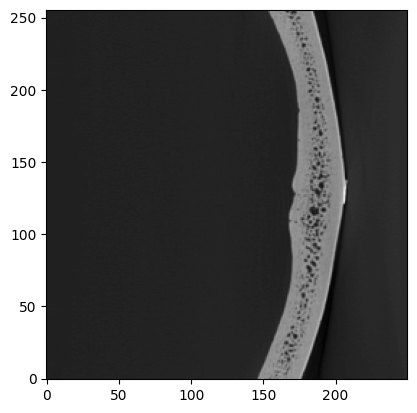

In [4]:
import pydicom

# define skull slice
skull_dicom = pydicom.dcmread("../data/skull_slice.dcm")
skull_array = skull_dicom.pixel_array.astype(np.int16)
skull_array = skull_array[:500, 600:-600]
skull_array = np.flipud(skull_array)
downsampling_factor = 2
new_shape = (skull_array.shape[0] // downsampling_factor, skull_array.shape[1] // downsampling_factor)
skull_array = jax.image.resize(skull_array, new_shape, method='nearest').T
plt.imshow(skull_array, cmap='gray')
plt.gca().invert_yaxis()
plt.show()

In [5]:
from jwave_utils import get_domain

# define spatial parameters
N = np.array(skull_array.shape).astype(int) # grid size [grid points]
dx = np.array([9.07935931401377e-5*downsampling_factor, 9.07935931401377e-5*downsampling_factor]) # grid spacing [m]
pml = np.array([20, 20]) # size of the perfectly matched layer [grid points]

domain = get_domain(N, dx)

In [6]:
# define real transducer positions
transducer_depth = pml[1] # depth of the transducer [grid points]
transducer_x_start = N[0]//2 - nelements//2 # start index of the transducer in the x-direction [grid points]
element_positions = np.array([
    np.linspace(transducer_x_start, transducer_x_start + nelements - 1, nelements),
    (N[1] - transducer_depth) * np.ones(nelements),
], dtype=int)
element_positions

array([[ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
        158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
        171, 172, 173, 174, 175],
       [230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
        230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
        230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
        230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
        230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
        230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
        230, 230,

In [7]:
# skull_thickness = int(6e-3 // dx[0]) # thickness of the skull [grid points]
# skull_array = np.zeros_like(skull_array)
# start_x_idx = 170
# skull_array[:, start_x_idx:start_x_idx + skull_thickness] = 1
# skull_circle_radius = int(3e-3 // dx[0]) # radius of the skull circle [grid points]

# # Swap the order of N[0] and N[1] in np.meshgrid
# y, x = np.meshgrid(np.arange(N[1]), np.arange(N[0]))
# skull_array[(x - N[0]//2+50)**2 + (y - start_x_idx)**2 < skull_circle_radius**2] = 0
# skull_array[(x - N[0]//2)**2 + (y - start_x_idx)**2 < skull_circle_radius**2] = 0
# skull_array[(x - N[0]//2-50)**2 + (y - start_x_idx)**2 < skull_circle_radius**2] = 0

# skull_array[skull_array == 1] = 30000

# plt.imshow(skull_array, cmap='gray')
# plt.gca().invert_yaxis()
# plt.show()

In [8]:
from jwave_utils import get_homogeneous_medium, get_skull_medium

# get mediums
c0 = 1500 # speed of sound in water [m/s]
speed_homogeneous, density_homogeneous = get_homogeneous_medium(domain, background_std=0)
speed_skull, density_skull = get_skull_medium(domain, skull_array, background_std=0)

scatterer_positions = np.array([[domain.N[0]//2, domain.N[1]//2]], dtype=int)
speed, density = get_skull_medium(domain, skull_array, scatterer_positions, 
                          background_std = 0.000, scatterer_radius=1, scatterer_contrast=1.1, 
                          background_seed=28)

In [9]:
from jwave.geometry import TimeAxis
from jwave.geometry import Medium
from jwave import FourierSeries

# define time axis
medium = Medium(domain, FourierSeries(jnp.expand_dims(speed_skull, -1), domain), FourierSeries(jnp.expand_dims(density_skull, -1), domain), pml_size=pml[0])
time_axis = TimeAxis.from_medium(medium, cfl=0.3)
# time_axis = TimeAxis(time_axis.dt, time_axis.t_end*2)

## Time reversal

In [ ]:
# define virtual transducer position beneath the skull
# virtual_positions = np.array([
#     np.linspace(0, N[0] - 1, N[0]),
#     (N[1] - transducer_depth) * np.ones(N[0]),
# ], dtype=int)
virtual_positions = element_positions.copy()
virtual_positions[1] -= 90

In [ ]:
ext = [0, N[1]*dx[1], N[0]*dx[0], 0]
plt.scatter(element_positions[1]*dx[1], element_positions[0]*dx[0],
            c='r', marker='o', s=5, label='transducer element')
plt.scatter(virtual_positions[1]*dx[1], virtual_positions[0]*dx[0],
            c='b', marker='o', s=5, label='virtual element')
plt.imshow(speed_skull, cmap='gray', extent=ext)
# plt.colorbar(label='Speed of sound [m/s]')
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.legend(prop={'size': 7})
plt.gca().invert_yaxis()
plt.show()

In [ ]:
from jwave_utils import get_plane_wave_excitation

angle = 0
virtual_sources, virtual_signal, virtual_carrier_signal = get_plane_wave_excitation(domain, time_axis, transducer_magnitude, transducer_frequency, dx[0], virtual_positions, angle=angle)

plt.plot(virtual_sources.signals[0])
plt.xlabel('Time point')
plt.ylabel('Amplitude [Pa]')
plt.show()

In [ ]:
from jwave_utils import get_data

# simulate data using jwave
virtual_pressure, virtual_data = get_data(speed_skull, density_skull, domain, time_axis, virtual_sources, element_positions)
virtual_pressure_skull, virtual_data_skull = get_data(speed_skull, density_skull, domain, time_axis, virtual_sources, element_positions)

In [ ]:
from jwave.utils import show_field

t_idx = 100
show_field(virtual_pressure_skull[t_idx])
plt.title(f"Pressure field at t={time_axis.to_array()[t_idx]} seconds")
plt.show()

In [ ]:
reverse_threshold = 740
virtual_data = jnp.squeeze(virtual_pressure_skull.params[:, element_positions[0], element_positions[1]])
virtual_data = jnp.flip(virtual_data, axis=0)
virtual_data = virtual_data.at[:int(time_axis.Nt - reverse_threshold), :].set(0)
virtual_data = jnp.roll(virtual_data, - int(time_axis.Nt - reverse_threshold), axis=0)
plt.imshow(virtual_data, aspect='auto', cmap='seismic')   
plt.show()

In [ ]:
from jwave.geometry import Sources

time_reversed_sources = Sources(
    positions=tuple(map(tuple, element_positions)),
    signals=jnp.array(virtual_data.T),
    dt=time_axis.dt,
    domain=domain,
)

plt.plot(time_axis.to_array(), time_reversed_sources.signals[0])
plt.xlabel('Time point')
plt.ylabel('Amplitude [Pa]')
plt.show()

In [ ]:
pressure_skull, data_skull = get_data(speed_skull, density_skull, domain, time_axis, time_reversed_sources, virtual_positions)

In [ ]:
from jwave.utils import show_field

t_idx = 700
show_field(pressure_skull[t_idx])
plt.title(f"Pressure field at t={time_axis.to_array()[t_idx]} seconds")
plt.show()

## Forward pass

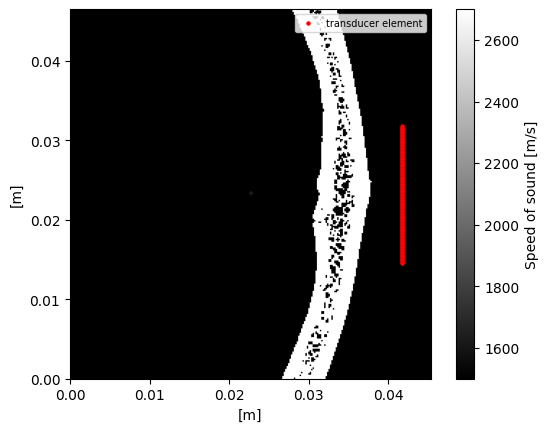

In [10]:
ext = [0, N[1]*dx[1], N[0]*dx[0], 0]
plt.scatter(element_positions[1]*dx[1], element_positions[0]*dx[0],
            c='r', marker='o', s=5, label='transducer element')
# plt.scatter(virtual_positions[1]*dx[1], virtual_positions[0]*dx[0],
#             c='b', marker='o', s=5, label='virtual element')
plt.imshow(speed, cmap='gray', extent=ext)
plt.colorbar(label='Speed of sound [m/s]')
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.legend(prop={'size': 7})
plt.gca().invert_yaxis()
plt.show()

In [11]:
from jwave_utils import get_plane_wave_excitation, get_data

# ABERRATION
angle = 0
sources_ab, signal_ab, carrier_signal_ab = get_plane_wave_excitation(domain, time_axis, transducer_magnitude, transducer_frequency, dx[0], element_positions, angle=angle)
_, data_ab = get_data(speed, density, domain, time_axis, sources_ab, element_positions)
_, data_homogeneous = get_data(speed_homogeneous, density_homogeneous, domain, time_axis, sources_ab, element_positions)
output_data_ab = data_ab - data_homogeneous

# # DE-ABERRATION
# _, data = get_data(speed, density, domain, time_axis, time_reversed_sources, element_positions)
# sources = Sources(
#     positions=tuple(map(tuple, element_positions)),
#     signals=jnp.flip(data, axis=0).T,
#     dt=time_axis.dt,
#     domain=domain,
# )
# _, data = get_data(speed_skull, density_skull, domain, time_axis, sources, virtual_positions)
# data = jnp.flip(data, axis=0)

# _, data_skull = get_data(speed_skull, density_skull, domain, time_axis, time_reversed_sources, element_positions)
# sources = Sources(
#     positions=tuple(map(tuple, element_positions)),
#     signals=jnp.flip(data_skull, axis=0).T,
#     dt=time_axis.dt,
#     domain=domain,
# )
# _, data_skull = get_data(speed_skull, density_skull, domain, time_axis, sources, virtual_positions)
# data_skull = jnp.flip(data_skull, axis=0)
# output_data = data - data_skull

In [ ]:
plt.imshow(data, aspect='auto', cmap='seismic')
plt.xlabel('Transducer elements')
plt.ylabel('Time point')
plt.show()

In [ ]:
plt.imshow(output_data, aspect='auto', cmap='seismic')
plt.xlabel('Transducer elements')
plt.ylabel('Time point')
plt.show()

# Reconstruction

In [ ]:
# from kwave.utils.filters import gaussian_filter
# from kwave.reconstruction.beamform import envelope_detection

# def postprocess_result(orig_res):
#     result = np.copy(orig_res)
#     for i in range(result.shape[0]):
#         result[i, :] = gaussian_filter(result[i, :], 1/dx[0], transducer_frequency, 100.0)
#     for i in range(result.shape[0]):
#         result[i, :] = envelope_detection(result[i, :])
#     return np.flipud(result).T

## Single angle

### Naive

In [ ]:
from beamforming_utils import get_receive_beamforming, get_receive_beamforming_medium_specific
signal_delay = (element_pitch * np.sin(angle) / c0) / time_axis.dt 
beam_time_axis = TimeAxis(time_axis.dt, len(output_data)*time_axis.dt)
_, beam_signal, carrier_signal = get_plane_wave_excitation(domain, beam_time_axis, transducer_magnitude, transducer_frequency, dx[0], virtual_positions, angle=angle)
res = get_receive_beamforming(domain, beam_time_axis, virtual_positions, output_data, beam_signal, carrier_signal, signal_delay)
# res = get_receive_beamforming_medium_specific(domain, medium, time_axis, element_positions, output_data, signal, carrier_signal, signal_delay)

In [ ]:
# bmode=postprocess_result(res)
plt.imshow(res.T, cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

### ntk

In [ ]:
from imaging.demodulate import demodulate_rf_to_iq
freq_sampling = 1/time_axis.dt
iq_signals, freq_carrier = demodulate_rf_to_iq(output_data, freq_sampling, freq_carrier=transducer_frequency)

In [ ]:
# N = domain.N[0]
Nz = domain.N[1] - transducer_depth
dx0 = domain.dx[0]

# Generate 1D arrays for x and z
x = np.linspace(-(domain.N[0]//2)*dx0, (domain.N[0]//2)*dx0, domain.N[0])
z = np.linspace(0, domain.N[1]*dx0, domain.N[1])

# Create 2D meshgrid for x and z
X, Z = np.meshgrid(x, z)

In [ ]:
from imaging.beamform import beamform_delay_and_sum

beamformed_signal = beamform_delay_and_sum(iq_signals, X, Z, freq_sampling, freq_carrier, pitch=element_pitch, tx_delays=np.zeros(iq_signals.shape[1]))

In [ ]:
beamformed_signal_2 = beamformed_signal.copy()
# beamformed_signal_2[:25, :] = 0

plt.imshow(np.abs(beamformed_signal_2), cmap='seismic')
plt.colorbar()
plt.show()


## Multiple angles

In [ ]:
angles = np.linspace(- 10*np.pi/180, 10*np.pi/180, 10)
results = []
for angle in angles:
    print(f"Angle: {angle}")
    sources, signal, carrier_signal = get_plane_wave_excitation(domain, time_axis, transducer_magnitude, transducer_frequency, dx[0], element_positions, angle=angle)
    _, data = get_data(speed, density, domain, time_axis, sources, element_positions)
    _, data_skull = get_data(speed_skull, density_skull, domain, time_axis, sources, element_positions)
    output_data = data-data_skull
    signal_delay = (element_pitch * np.sin(angle) / c0) / time_axis.dt
    res = get_receive_beamforming(domain, time_axis, element_positions, output_data, signal, carrier_signal, signal_delay)
    # res = get_receive_beamforming_medium_specific(domain, medium, time_axis, element_positions, output_data, signal, carrier_signal, signal_delay)
    results.append(res)

In [ ]:
compounded_res = np.sum(results, axis=0)
# compounded_bmode=postprocess_result(compounded_res)
# bmodes = [postprocess_result(res) for res in results]
# compounded_bmode = np.sum(bmodes, axis=0)

plt.imshow(compounded_res.T, cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

## Saachi method

In [12]:
from jwave import FourierSeries
from jwave.geometry import Sensors
from jwave.acoustics import simulate_wave_propagation

sound_speed = FourierSeries(jnp.expand_dims(speed_skull, -1), domain)
density = FourierSeries(jnp.expand_dims(density_skull, -1), domain)
medium = Medium(domain=domain, sound_speed=sound_speed, density=density, pml_size=20)
sensors = Sensors(element_positions)
pwave = simulate_wave_propagation(medium, time_axis, sources=sources_ab)
data = pwave.params[:, element_positions[0], element_positions[1], 0].T

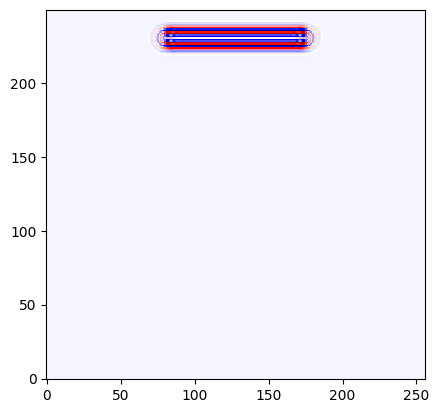

In [13]:
plt.imshow(pwave.params[100, :, :, 1].T, cmap='seismic', interpolation='nearest')
plt.gca().invert_yaxis()

In [14]:
from jwave.geometry import Sources

adjoint_sources = Sources(
    positions=tuple(map(tuple, element_positions)),
    signals=jnp.vstack([np.flip(data[i] - data_ab.T[i]) for i in range(element_positions.shape[1])]),
    dt=time_axis.dt,
    domain=domain,
)
adjoint_pwave = np.squeeze(simulate_wave_propagation(medium, time_axis, sources=adjoint_sources).params)

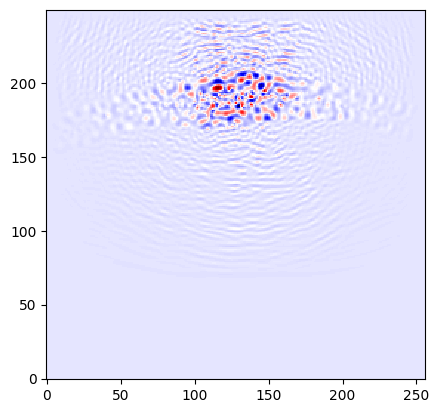

In [15]:
plt.imshow(adjoint_pwave[900, :, :].T, cmap='seismic', interpolation='nearest')
plt.gca().invert_yaxis()

In [29]:
max_values = jnp.max(pwave.params, axis=0) + 1e-6
normalized_pwave_params = pwave.params / max_values
I = np.sum(np.squeeze(normalized_pwave_params) * np.flip(adjoint_pwave, axis=0), axis=0)
I = I.at[:, 160:].set(0)

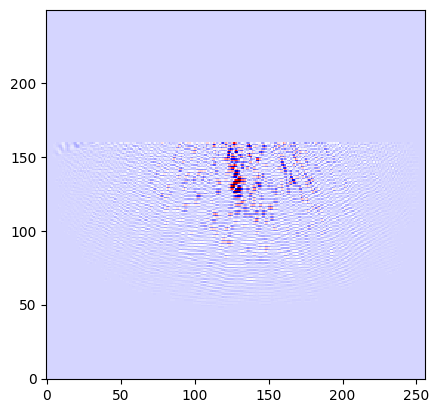

In [30]:
plt.imshow(I.T, cmap='seismic', interpolation='nearest')
plt.gca().invert_yaxis()

## Gradient

In [31]:
from jax import value_and_grad
from jwave_utils import get_data_only
from solver_utils import linear_loss, nonlinear_loss

params = speed_skull

# compute first linear gradient
# J = jax.jacrev(get_data_only, argnums=0)(jnp.array(speed), density_homogenous, domain, time_axis, sources, element_positions)
# linear_val_and_grad = value_and_grad(linear_loss, argnums=0)
# linear_loss, linear_gradient = linear_val_and_grad(params, J, output_data)

# compute first nonlinear gradient
nonlinear_val_and_grad = value_and_grad(nonlinear_loss, argnums=0)
nonlinear_loss, nonlinear_gradient = nonlinear_val_and_grad(params, data_ab, density_skull, domain, time_axis, sources_ab, element_positions)
nonlinear_gradient = nonlinear_gradient.at[:, 160:].set(0) # apply mask
print(f"Nonlinear loss: {nonlinear_loss}")

Nonlinear loss: 62439.203125


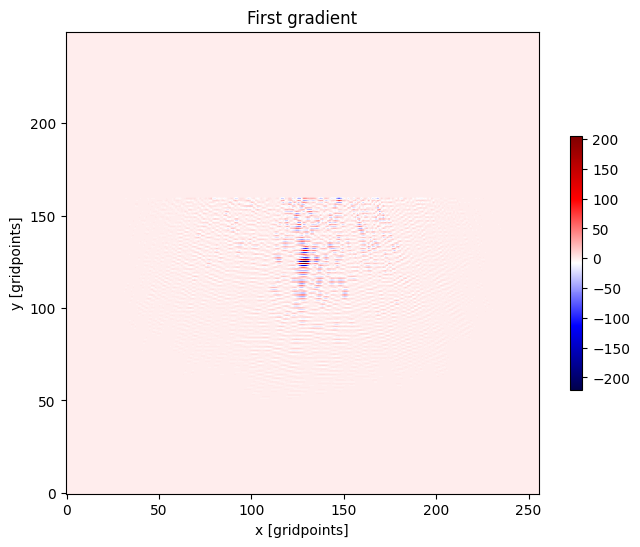

In [32]:
# Viualize
plt.figure(figsize=(8, 6))
plt.imshow(nonlinear_gradient.T, cmap='seismic')
plt.title("First gradient")
plt.xlabel('x [gridpoints]')
plt.ylabel('y [gridpoints]')
plt.gca().invert_yaxis()
plt.colorbar(shrink=0.55)
plt.show()

In [33]:
from jax.example_libraries import optimizers
from tqdm import tqdm
from jwave.signal_processing import smooth

def smooth_fun(x):
    # x = gradient.on_grid[..., 0]
    for _ in range(3):
        x = smooth(x)
    return x

losshistory = []
reconstructions = []
num_steps = 50

# Define optimizer
learning_rate = 1
# init_fun, update_fun, get_params = optimizers.adam(learning_rate)
init_fun, update_fun, get_params = optimizers.sgd(learning_rate)
opt_state = init_fun(params)

# Define and compile the update function
@jit
def update(opt_state, k):
    v = get_params(opt_state)
    lossval, gradient = nonlinear_val_and_grad(v, data_ab, density_skull, domain, time_axis, sources_ab, element_positions)
    # gradient = smooth_fun(gradient)
    gradient = gradient.at[:, 160:].set(0)
    gradient = gradient / jnp.max(jnp.abs(gradient))
    return lossval, update_fun(k, gradient, opt_state)

# Main loop
pbar = tqdm(range(num_steps))
for k in pbar:
    lossval, opt_state = update(opt_state, k)

    ## For logging
    new_params = get_params(opt_state)
    reconstructions.append(new_params)
    losshistory.append(lossval)
    pbar.set_description("Loss: {}".format(lossval))

  0%|          | 0/50 [00:00<?, ?it/s]

Loss: 14373.1357421875: 100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


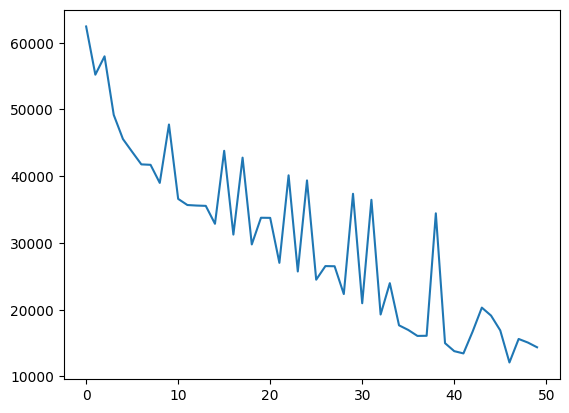

In [34]:
plt.plot(losshistory)

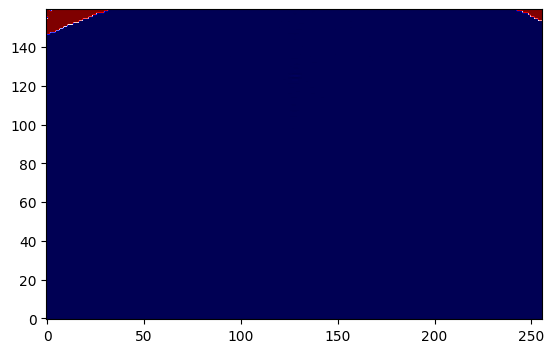

In [35]:
plt.imshow(reconstructions[-1][:,:160].T, cmap='seismic')
plt.gca().invert_yaxis()
plt.show()

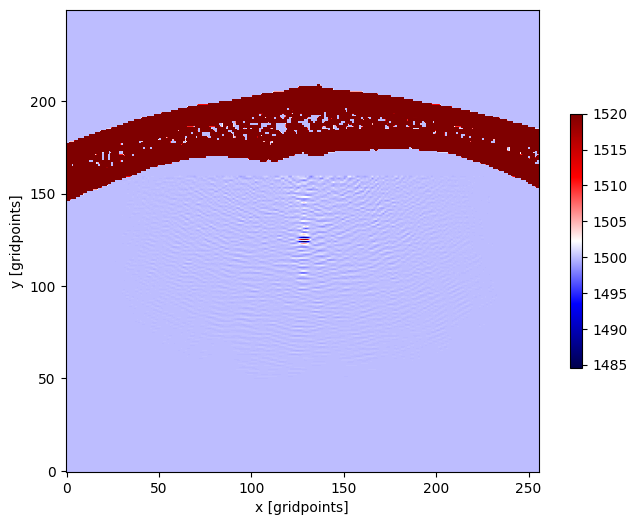

In [36]:
# Viualize
plt.figure(figsize=(8, 6))
plt.imshow(reconstructions[-1].T, cmap='seismic', vmax=1520)
plt.xlabel('x [gridpoints]')
plt.ylabel('y [gridpoints]')
plt.gca().invert_yaxis()
plt.colorbar(shrink=0.55)
plt.show()